In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif
from interpret import glassbox,show

In [88]:
df = pd.read_csv('Doceree-HCP_Train.csv', encoding='latin1')

In [89]:
df.head()

,ID,DEVICETYPE,PLATFORM_ID,BIDREQUESTIP,USERPLATFORMUID,USERCITY,USERZIPCODE,USERAGENT,PLATFORMTYPE,CHANNELTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,1001,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
1,1002,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/deci...,Bone Marrow|Radiography|Chronic|Oncology|Psych...,NaN,0.0
2,1003,Desktop,2,66.232.79.22,a698de4b-e200-46dd-b5fb-40402175ae18,New Meadows,83654.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
3,1004,Desktop,3,137.54.125.246,45967533-75c8-4fbd-a00c-e6ff20447aaa,NaN,229114624.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://globalrph.com/medcalcs/warfarin-mainte...,Dental|Total|Clinical|Pharmacology|Physicians|...,2084P0800X,1.0
4,1005,Mobile,7,174.202.231.99,a17e25be-532d-4cf5-b916-9308c8c3961f,Houston,77008.0,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1_1 like...,Online Medical Journal,Website,https://www.cureus.com/articles/58184-a-review...,Critical Care|Emergency Medicine|General Pract...,NaN,0.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               113937 non-null  int64  
 1   DEVICETYPE       113937 non-null  object 
 2   PLATFORM_ID      113937 non-null  int64  
 3   BIDREQUESTIP     113937 non-null  object 
 4   USERPLATFORMUID  113933 non-null  object 
 5   USERCITY         107578 non-null  object 
 6   USERZIPCODE      109345 non-null  float64
 7   USERAGENT        113935 non-null  object 
 8   PLATFORMTYPE     113937 non-null  object 
 9   CHANNELTYPE      113937 non-null  object 
 10  URL              113937 non-null  object 
 11  KEYWORDS         113937 non-null  object 
 12  TAXONOMY         32313 non-null   object 
 13  IS_HCP           113936 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 12.2+ MB


In [91]:
for i in df.columns:
    if len(set(df[i]))<=60:
        print(f"{i}  {set(df[i])}")

DEVICETYPE  {'Unknown', 'Tablet', 'Mobile', 'Desktop'}
PLATFORM_ID  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16}
PLATFORMTYPE  {'Online Learning Portal', 'Medical News Platform', 'Electronic Health Record', 'Tele-medicine Platform', 'Online Medical Journal'}
CHANNELTYPE  {'Website'}
IS_HCP  {0.0, 1.0, nan}


In [92]:
def url_map(x):
    x=x[12:]
    p=x.split('.')
    x=p[0]
    return x

df['URL'] = df['URL'].map(url_map)


In [93]:
keywords=dict()
for i in list(df['KEYWORDS']):
    temp=i.split('|')
    for j in temp:
        if j in keywords:
            keywords[j]=keywords[j]+1
        else:
            keywords[j]=0
keywords_list=[(keywords[i],i) for i in keywords]
keywords_list.sort(reverse=True)
keywords_sortedbyfreq=[i for (j,i) in keywords_list]

In [94]:
def keyword_map(x):
    x_list=x.split('|')
    x=0
    for i in x_list:
        x+=keywords_sortedbyfreq.index(i)
    return x

df['KEYWORDS'] = df['KEYWORDS'].map(keyword_map)


In [95]:
le_devicetype=LabelEncoder()
le_devicetype.fit(df['DEVICETYPE'])
df['DEVICETYPE']=le_devicetype.transform(df['DEVICETYPE'])

le_platformtype=LabelEncoder()
le_platformtype.fit(df['PLATFORMTYPE'])
df['PLATFORMTYPE']=le_platformtype.transform(df['PLATFORMTYPE'])

le_channeltype=LabelEncoder()
le_channeltype.fit(df['CHANNELTYPE'])
df['CHANNELTYPE']=le_channeltype.transform(df['CHANNELTYPE'])

url_encoder=LabelEncoder()
url_encoder.fit(df['URL'])
df['URL']=url_encoder.transform(df['URL'])

taxonomy_encoder=LabelEncoder()
taxonomy_encoder.fit(df['TAXONOMY'])
df['TAXONOMY']=taxonomy_encoder.transform(df['TAXONOMY'])

In [96]:
df.drop(columns=['BIDREQUESTIP','USERPLATFORMUID','USERCITY','USERAGENT','CHANNELTYPE'], inplace=True)


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            113937 non-null  int64  
 1   DEVICETYPE    113937 non-null  int32  
 2   PLATFORM_ID   113937 non-null  int64  
 3   USERZIPCODE   109345 non-null  float64
 4   PLATFORMTYPE  113937 non-null  int32  
 5   URL           113937 non-null  int32  
 6   KEYWORDS      113937 non-null  int64  
 7   TAXONOMY      113937 non-null  int32  
 8   IS_HCP        113936 non-null  float64
dtypes: float64(2), int32(4), int64(3)
memory usage: 6.1 MB


In [98]:
df.isnull().sum()
df.fillna(0)

,ID,DEVICETYPE,PLATFORM_ID,USERZIPCODE,PLATFORMTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,1001,0,2,97206.0,3,2,279,207,0.0
1,1002,0,2,22202.0,3,2,3306,207,0.0
2,1003,0,2,83654.0,3,2,279,207,0.0
3,1004,0,3,229114624.0,3,1,686,149,1.0
4,1005,1,7,77008.0,3,5,3359,207,0.0
...,...,...,...,...,...,...,...,...,...
113932,114933,0,2,19120.0,3,3,406,69,1.0
113933,114934,0,2,914014213.0,3,3,360,149,1.0
113934,114935,0,7,98105.0,3,5,2238,112,1.0
113935,114936,1,2,19808.0,3,6,5931,149,1.0


In [99]:
#Frequently occuring values in a dataset
for i in df.columns:
    if i!='ID':
        print(i)
        print(df[i].mode()[0])
        print(f'{(df[i].value_counts()[df[i].mode()[0]]/len(df[i]))*100} % ')
        print('========================')

DEVICETYPE
0
68.83014297374865 % 
PLATFORM_ID
2
69.46909256870025 % 
USERZIPCODE
63169.0
1.857166679831837 % 
PLATFORMTYPE
3
96.64990301657934 % 
URL
5
18.35488032860265 % 
KEYWORDS
914
4.666614005985764 % 
TAXONOMY
207
71.63959029990258 % 
IS_HCP
0.0
70.0000877678015 % 


## Inferences:

- **CHANNELTYPE** - All data points are filled with 'Website'. Every user accesses through website channel. It is a redundant column
- **PLATFORMTYPE** - 96% of users visit Online Medical Journals. 
- **IS_HCP** - 70 % of users are not HCP. Might lead to overfitting of the data due to imbalance of information
- **DEVICETYPE** - 68% of users use desktop
- **PLATFORMID** - 69 % of users used platform of ID=2


## CORRELATION HEATMAP

In [100]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            113937 non-null  int64  
 1   DEVICETYPE    113937 non-null  int32  
 2   PLATFORM_ID   113937 non-null  int64  
 3   USERZIPCODE   109345 non-null  float64
 4   PLATFORMTYPE  113937 non-null  int32  
 5   URL           113937 non-null  int32  
 6   KEYWORDS      113937 non-null  int64  
 7   TAXONOMY      113937 non-null  int32  
 8   IS_HCP        113936 non-null  float64
dtypes: float64(2), int32(4), int64(3)
memory usage: 6.1 MB


In [108]:
data = pd.DataFrame(df)
data.fillna(0,inplace=True)
corr_mat=[]
for i in data.columns:
    temp=[]
    for j in data.columns:
        temp.append(spearmanr(data[i],data[j]).correlation)
    corr_mat.append(temp)


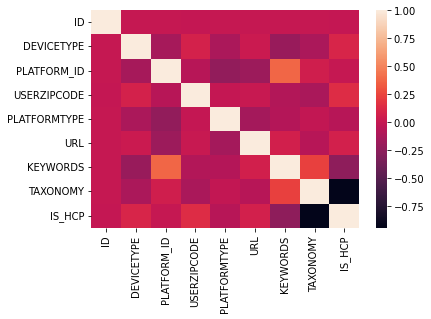

In [109]:
sns.heatmap(data=corr_mat,xticklabels=data.columns,yticklabels=data.columns)
plt.show()

### Inferences:

- High positive correlation between taxonomy and is_hcp 

In [110]:
print(df.info())
X=df.drop(columns=['IS_HCP'],inplace=False)
y=df['IS_HCP']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            113937 non-null  int64  
 1   DEVICETYPE    113937 non-null  int32  
 2   PLATFORM_ID   113937 non-null  int64  
 3   USERZIPCODE   113937 non-null  float64
 4   PLATFORMTYPE  113937 non-null  int32  
 5   URL           113937 non-null  int32  
 6   KEYWORDS      113937 non-null  int64  
 7   TAXONOMY      113937 non-null  int32  
 8   IS_HCP        113937 non-null  float64
dtypes: float64(2), int32(4), int64(3)
memory usage: 6.1 MB
None


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            113937 non-null  int64  
 1   DEVICETYPE    113937 non-null  int32  
 2   PLATFORM_ID   113937 non-null  int64  
 3   USERZIPCODE   113937 non-null  float64
 4   PLATFORMTYPE  113937 non-null  int32  
 5   URL           113937 non-null  int32  
 6   KEYWORDS      113937 non-null  int64  
 7   TAXONOMY      113937 non-null  int32  
 8   IS_HCP        113937 non-null  float64
dtypes: float64(2), int32(4), int64(3)
memory usage: 6.1 MB


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
model=glassbox.ExplainableBoostingClassifier()
model.fit(X_train,y_train)


ExplainableBoostingClassifier()

In [116]:
y_pred=model.predict(X_test)

In [117]:
print(accuracy_score(np.array(y_test.astype(str)),y_pred))

0.9973231525364227


In [28]:
for i in range(len(y_pred)):
    print(np.array(y_test.astype(str))[i],y_pred[i])

1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0


1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0


1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0


0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0


0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0


1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0


0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0


1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0


In [30]:
model.expl

array(['1.0', '1.0', '0.0', ..., '1.0', '0.0', '0.0'], dtype=object)

In [22]:
y_pred[0]

'1.0'

In [23]:
len(y_pred)

22788

In [24]:
y_test

15343     1.0
55980     1.0
46941     0.0
42395     1.0
58127     0.0
         ... 
66371     1.0
61423     0.0
112656    1.0
91776     0.0
12339     0.0
Name: IS_HCP, Length: 22788, dtype: float64

In [35]:
show(model.explain_global())

<!-- http://127.0.0.1:7001/2455214418384/ -->

In [37]:
df['URL']

0          666
1          708
2          666
3          327
4         1631
          ... 
113932     819
113933     852
113934    1576
113935    2387
113936    3648
Name: URL, Length: 113937, dtype: int32

In [52]:
df.isnull().sum()

ID                 0
DEVICETYPE         0
PLATFORM_ID        0
BIDREQUESTIP       0
USERPLATFORMUID    0
USERCITY           0
USERZIPCODE        0
USERAGENT          0
PLATFORMTYPE       0
URL                0
KEYWORDS           0
TAXONOMY           0
IS_HCP             0
dtype: int64

In [68]:
test=pd.read_csv("Doceree-HCP_Test.csv")

In [70]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28493 entries, 0 to 28492
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               28493 non-null  int64  
 1   DEVICETYPE       28493 non-null  object 
 2   PLATFORM_ID      28493 non-null  int64  
 3   BIDREQUESTIP     28493 non-null  object 
 4   USERPLATFORMUID  28493 non-null  object 
 5   USERCITY         26934 non-null  object 
 6   USERZIPCODE      27378 non-null  float64
 7   USERAGENT        28492 non-null  object 
 8   PLATFORMTYPE     28493 non-null  object 
 9   CHANNELTYPE      28493 non-null  object 
 10  URL              28493 non-null  object 
 11  KEYWORDS         28493 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.6+ MB
None


In [71]:
kundi=test
kundi.drop(columns=['ID'],inplace=True)

In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28493 entries, 0 to 28492
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DEVICETYPE       28493 non-null  object 
 1   PLATFORM_ID      28493 non-null  int64  
 2   BIDREQUESTIP     28493 non-null  object 
 3   USERPLATFORMUID  28493 non-null  object 
 4   USERCITY         26934 non-null  object 
 5   USERZIPCODE      27378 non-null  float64
 6   USERAGENT        28492 non-null  object 
 7   PLATFORMTYPE     28493 non-null  object 
 8   CHANNELTYPE      28493 non-null  object 
 9   URL              28493 non-null  object 
 10  KEYWORDS         28493 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 2.4+ MB


['False',
 'Clinical',
 'Medicine',
 'Cardiology',
 'Urology',
 'Dermatology',
 'Oncology',
 'Neurology',
 'Psychiatry',
 'General',
 'Rheumatology',
 'Gastroenterology',
 'Ophthalmology',
 'Health',
 'Diagnosis',
 'Total',
 'Surgery',
 'Oral',
 'Chronic',
 'Cardiovascular',
 'Small',
 'Pediatrics',
 'Surgical',
 'Transplantation',
 'Technology',
 'Asthma',
 'Arthritis',
 'Large',
 'Metabolic',
 'Orthopedics',
 '',
 'the',
 'Autoimmune',
 'disease',
 'Lung',
 'Trauma',
 'oncology',
 'dermatology',
 'hematology',
 'urology',
 'clinical',
 'pain',
 'Liver',
 'Child',
 'general',
 'health',
 'Pathology',
 'Physicians',
 'cardiology',
 'Cardiac',
 'Resuscitation',
 'Controlled',
 'Critical Care',
 'Endocrine',
 'nephrology',
 'Hepatology',
 'Male',
 'Intravenous',
 'Refractory',
 'pediatrics',
 'Induced',
 'surgery',
 'Rehabilitation',
 'Preventive',
 'Rheumatoid',
 'Specialties',
 'Dentistry',
 'Genetic',
 'Preventive Medicine',
 'Anemia',
 'Biopsy',
 'Emergency Medicine',
 'Erythema',
 '

In [ ]:
keywords_count=dict()
for i in list(df['KEYWORDS']):
    temp=i.split('|')
    for j in temp:
        if j in keywords:
            keywords[j]=keywords[j]+
        else:
            keywords[j]=0

In [103]:
df

,ID,DEVICETYPE,PLATFORM_ID,USERZIPCODE,PLATFORMTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,1001,0,2,97206.0,3,2,279,207,0.0
1,1002,0,2,22202.0,3,2,3306,207,0.0
2,1003,0,2,83654.0,3,2,279,207,0.0
3,1004,0,3,229114624.0,3,1,686,149,1.0
4,1005,1,7,77008.0,3,5,3359,207,0.0
...,...,...,...,...,...,...,...,...,...
113932,114933,0,2,19120.0,3,3,406,69,1.0
113933,114934,0,2,914014213.0,3,3,360,149,1.0
113934,114935,0,7,98105.0,3,5,2238,112,1.0
113935,114936,1,2,19808.0,3,6,5931,149,1.0


In [34]:
len(df)

113937

In [41]:
df

,ID,DEVICETYPE,PLATFORM_ID,BIDREQUESTIP,USERPLATFORMUID,USERCITY,USERZIPCODE,USERAGENT,PLATFORMTYPE,CHANNELTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,1001,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,cancertherapyadvisor,279,NaN,0.0
1,1002,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,cancertherapyadvisor,3306,NaN,0.0
2,1003,Desktop,2,66.232.79.22,a698de4b-e200-46dd-b5fb-40402175ae18,New Meadows,83654.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,cancertherapyadvisor,279,NaN,0.0
3,1004,Desktop,3,137.54.125.246,45967533-75c8-4fbd-a00c-e6ff20447aaa,NaN,229114624.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,alrph,686,2084P0800X,1.0
4,1005,Mobile,7,174.202.231.99,a17e25be-532d-4cf5-b916-9308c8c3961f,Houston,77008.0,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1_1 like...,Online Medical Journal,Website,cureus,3359,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,114933,Desktop,2,68.82.97.126,051e4a06-4cb4-4b97-b0b1-d1c6a2b8e2c2,Philadelphia,19120.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,Online Medical Journal,Website,clinicaladvisor,406,207RP1001X,1.0
113933,114934,Desktop,2,104.172.11.109,3289bba5-4a50-4b61-a5cc-68596bbdc2bf,Van Nuys,914014213.0,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,Online Medical Journal,Website,clinicaladvisor,360,2084P0800X,1.0
113934,114935,Desktop,7,174.21.94.113,9c36e90c-caa7-4323-8431-fb84f8293972,NaN,98105.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,cureus,2238,208000000X,1.0
113935,114936,Mobile,2,69.253.129.131,afc27760-31f7-4f6e-aa08-90d8a96525d0,Wilmington,19808.0,Mozilla/5.0 (iPhone; CPU iPhone OS 15_6_1 like...,Online Medical Journal,Website,dermatologyadvisor,5931,2084P0800X,1.0
